# FAST-EM import
---
**Author**: Ryan Lane  
**Date**: 6 April 2022

#### Overview
Quickly imports a FAST-EM project to `render-ws`.

Assumes data is stored as

Stack | Filepath
- | -
raw | `/.../asm_service/{date}/{project}/{section}/{row}_{col}_{zoom}.tiff`
corrected | `/.../asm_service/{date}/{stack}/{section}/corrected/{row}_{col}_{zoom}.tiff`

and outputs mipmaps of each field's pyramidal tiff to

Stack | Filepath
- | -
raw | `/.../{project}/raw/{section}/{row}_{col}/{zoom}.tif`
corrected | `/.../{project}/corrected/{section}/{row}_{col}/{zoom}.tif`

**Warning**:
Check filepath tree carefully before executing.

In [1]:
from pathlib import Path
import re
from ruamel.yaml import YAML

from tqdm.notebook import tqdm
from bs4 import BeautifulSoup as Soup
import numpy as np
import pandas as pd
from tifffile import TiffFile

import renderapi
import icatapi
from renderapi.transform import AffineModel

In [2]:
# Indirectly enable autocomplete
%config Completer.use_jedi = False

# pandas display options
pd.set_option('display.max_colwidth', 20)

#### Connect to `render-ws`

In [3]:
# render parameters
owner = 'rlane'
project = '20220404_02_demo_Brain_10us'

# Create a renderapi.connect.Render object
render_connect_params = {
    'host': 'sonic.tnw.tudelft.nl',
    'port': 8080,
    'owner': owner,
    'project': project,
    'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
    'memGB': '2G',
}
render = renderapi.connect(**render_connect_params)
render.make_kwargs()

{'host': 'http://sonic.tnw.tudelft.nl',
 'port': 8080,
 'owner': 'rlane',
 'project': '20220404_02_demo_Brain_10us',
 'client_scripts': '/home/catmaid/render/render-ws-java-client/src/main/scripts',
 'client_script': '/home/catmaid/render/render-ws-java-client/src/main/scripts/run_ws_client.sh',
 'memGB': '2G'}

#### Import and export directories

In [4]:
# Import from
dir_FASTEM = Path('/long_term_storage/asm_storage/asm_service/2022-04-04/02_demo_Brain_10us')
# Export to
dir_project = Path(f"/long_term_storage/{owner}/FAST-EM/projects/{project}/")

# Stack directory
!ls -l $dir_FASTEM

total 32
drwxrwxrwx 3 asmftp asmftp  8192 Apr  4 20:55 Ribbon_1_section_3_ROA-1
drwxrwxrwx 3 asmftp asmftp 16384 Apr  4 19:19 Ribbon_1_section_5_ROA-1


#### Section mapping

In [34]:
# Assume subdirectories of FAST-EM directories are different sections (durr)
dir_sections = sorted([dir_ for dir_ in dir_FASTEM.iterdir() if dir_.is_dir()])
d_sections = {i: d.name for i, d in enumerate(dir_sections)}
d_sections

{0: 'Ribbon_1_section_3_ROA-1', 1: 'Ribbon_1_section_5_ROA-1'}

## 1) Create mipmaps
---

#### Filepath layout
Mimaps of each FAST-EM field are output to
`{dir_project}/{stack}/{sectionId}/{row}_{col}/{zoom}.tif` e.g.

In [6]:
# %%bash
# ls -l /long_term_storage/rlane/FAST-EM/projects/20220404_02_demo_Brain_10us/raw/Ribbon_1_section_3_ROA-1/003_004/

In [7]:
from tifffile import TiffWriter

def create_mipmaps(tiff, dir_out, metadata):
    """Create mipmaps from multi-page tiff"""
    # Unpack pages
    for i, page in enumerate(tiff.pages):
        # Grayscale uint16 image
        image = page.asarray()
        # Write tiff
        fp = dir_out / f"{i}.tif"
        with TiffWriter(fp.as_posix()) as tif:
            tif.save(image, metadata=metadata)

#### Raw

In [8]:
# Loop through section directories
for z, dir_section in tqdm(enumerate(dir_sections),
                           total=len(dir_sections)):

    # Loop through tiffs in each section
    for fp in tqdm(list(dir_section.glob('[0-9]*_[0-9]*_0.tiff'))):

        # Read tiff
        tiff = TiffFile(fp)
        # Extract metadata
        metadata = {tag.name: tag.value for tag in tiff.pages[0].tags}
        # Infer row, col
        row, col = [int(i) for i in re.findall(r'\d+', fp.stem)][:2]

        # Set directory to output mipmaps
        dir_mipmaps = dir_project / 'raw' / dir_section.name / f"{row:03d}_{col:03d}"
        dir_mipmaps.mkdir(parents=True, exist_ok=True)
        # Create mipmaps
        create_mipmaps(tiff, dir_mipmaps, metadata)    

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

#### Corrected

In [9]:
# Loop through section directories
for z, dir_section in tqdm(enumerate(dir_sections),
                           total=len(dir_sections)):

    # Loop through tiffs in each section
    for fp in tqdm(list(dir_section.glob('corrected/[0-9]*_[0-9]*_0.tiff'))):

        # Read tiff
        tiff = TiffFile(fp)
        # Extract metadata
        metadata = {tag.name: tag.value for tag in tiff.pages[0].tags}
        # Infer row, col
        row, col = [int(i) for i in re.findall(r'\d+', fp.stem)[:2]]

        # Set directory to output mipmaps
        dir_mipmaps = dir_project / 'corrected' / dir_section.name / f"{row:03d}_{col:03d}"
        dir_mipmaps.mkdir(parents=True, exist_ok=True)
        # Create mipmaps
        create_mipmaps(tiff, dir_mipmaps, metadata)    

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

## 2) Create tile specifications
---

#### Filepath layout
Reminder that mimaps of each FAST-EM field are output to
`{dir_project}/{stack}/{sectionId}/{row}_{col}/{zoom}.tif`

In [10]:
import json
from renderapi.image_pyramid import ImagePyramid, MipMapLevel

In [28]:
dir_mipmap

PosixPath('/long_term_storage/asm_storage/asm_service/2022-04-04/02_demo_Brain_10us/Ribbon_1_section_3_ROA-1/000_000_0.tiff')

In [35]:
# Parameters
overlap = 10  # % -- guess

# Collect tile specifications
tile_dicts = []
# Loop through stack directories
for dir_stack in tqdm(list(dir_project.iterdir())):
    # Set stack name ('raw' or 'corrected')
    stack = dir_stack.name

    # Loop through section directories
    for z, sectionId in tqdm(d_sections.items()):

        # Loop through mipmap directories within each section
        dir_section = dir_stack / sectionId
        for dir_mipmap in tqdm(list(dir_section.glob('[0-9]*_[0-9]*')),
                               leave=False):

            # Read base-level tiff
            fp = dir_mipmap / '0.tif'
            tiff = TiffFile(fp)
            # Parse tiff tags for metadata
            md = json.loads(tiff.pages[0].description)
            # Infer row, col
            row, col = [int(i) for i in re.findall(r'\d+', fp.parent.name)[:2]]
            # Set translation based on overlap guess
            x0 = col * (1 - overlap/100) * md['ImageWidth']
            y0 = row * (1 - overlap/100) * md['ImageLength']

            # Create nested MipMapLevels
            mmls = []
            for mmfp in sorted(dir_mipmap.glob('[0-9].tif')):
                level = mmfp.stem
                imageUrl = f"https://sonic.tnw.tudelft.nl{mmfp.as_posix()}"
                mml = MipMapLevel(level, imageUrl=imageUrl)
                mmls.append(mml)
            # Create ImagePyramid from MipMapLevels
            ip = ImagePyramid({m.level: m.mipmap for m in mmls})

            # Handle missing DateTime metadata in corrected tiffs
            try:
                acqtime = pd.to_datetime(md['DateTime'])
            except KeyError:
                acqtime = -1

            # Build up tile specification
            ts = {}
            ts['stack'] = stack
            ts['sectionId'] = sectionId
            ts['z'] = z
            ts['tileId'] = f'{stack[:3]}-S{z:03d}-{row:03d}x{col:03d}'
            ts['acqtime'] = acqtime
            ts['width'] = md['ImageWidth']
            ts['height'] = md['ImageLength']
            ts['imageRow'] = row
            ts['imageCol'] = col
            ts['imagePyramid'] = ip
            ts['minint'] = 0
            ts['maxint'] = 65535
            ts['tforms'] = [AffineModel(B0=x0, B1=y0)]
            tile_dicts.append(ts)

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/156 [00:00<?, ?it/s]

  0%|          | 0/487 [00:00<?, ?it/s]

#### Create stack DataFrames

In [36]:
# Create DataFrame from list of tile specifications
df_stacks = pd.DataFrame(tile_dicts)

# Sneak peak
df_stacks.groupby('stack')\
         .apply(lambda x: x.sample(3))

stack            sectionId  z            tileId  \
stack                                                                 
corrected 1204  corrected  Ribbon_1_section...  1  cor-S001-014x013   
          873   corrected  Ribbon_1_section...  1  cor-S001-002x018   
          960   corrected  Ribbon_1_section...  1  cor-S001-005x021   
raw       579         raw  Ribbon_1_section...  1  raw-S001-015x003   
          253         raw  Ribbon_1_section...  1  raw-S001-003x013   
          347         raw  Ribbon_1_section...  1  raw-S001-006x023   

                            acqtime  width  height  imageRow  imageCol  \
stack                                                                    
corrected 1204                   -1   6400    6400        14        13   
          873                    -1   6400    6400         2        18   
          960                    -1   6400    6400         5        21   
raw       579   2022-04-04 16:26:53   6400    6400        15         3   
          253   2022-04-04 15:39:02   6400    6400         3        13   
          347   2022-04-04 15:52:50   6400    6400         6        23   

                   imagePyramid  minint  maxint               tforms  
stack                                                                 
corrected 1204  [0, 1, 2, 3, 4]       0   65535  [M=[[1.000000,0....  
          873   [0, 1, 2, 3, 4]       0   65535  [M=[[1.000000,0....  
          960   [0, 1, 2, 3, 4]       0   65535  [M=[[1.000000,0....  
raw       579      [0, 1, 2, 3]       0   65535  [M=[[1.000000,0....  
          253      [0, 1, 2, 3]       0   65535  [M=[[1.000000,0....  
          347      [0, 1, 2, 3]       0   65535  [M=[[1.000000,0....

### Set intensity levels
Sample `n` images/section to determine reasonable min/max intensity values.

In [37]:
# Set parameters
n = 10          # sample size (per section)
pcts = (1, 99)  # % for intensity clipping
stacks = df_stacks['stack'].unique().tolist()
z_values = df_stacks['z'].unique().tolist()

# Loop through stacks
for stack, df_stack in tqdm(df_stacks.groupby('stack'),
                            total=len(stacks)):

    # Loop through sections
    for z, tileset in tqdm(df_stack.groupby('z'),
                           total=len(z_values),
                           leave=False):

        # Sample filepaths
        fps = tileset.sample(n)['imagePyramid']\
                      .apply(lambda x: x[0]['imageUrl'])\
                      .tolist()

        # Collect min/max intensity values
        minints = []
        maxints = []
        # Loop through sample tiles
        for fp in tqdm(fps, leave=False):

            # Load tiff image
            fp_tiff = fp.split('.nl')[1]
            tiff = TiffFile(fp_tiff)
            image = tiff.asarray()

            # Get intensity percentiles
            minint, maxint = np.percentile(image, pcts)
            minints.append(minint)
            maxints.append(maxint)

        # Set min/max intensity
        df_stacks.loc[(df_stacks['stack'] == stack) &\
                      (df_stacks['z'] == z), 'minint'] = np.mean(minints, dtype=int)
        df_stacks.loc[(df_stacks['stack'] == stack) &\
                      (df_stacks['z'] == z), 'maxint'] = np.mean(maxints, dtype=int)

# Sneak peak
df_stacks.groupby('stack')\
         .apply(lambda x: x.sample(4))

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

stack            sectionId  z            tileId  \
stack                                                                 
corrected 912   corrected  Ribbon_1_section...  1  cor-S001-004x001   
          857   corrected  Ribbon_1_section...  1  cor-S001-002x002   
          957   corrected  Ribbon_1_section...  1  cor-S001-005x018   
          1077  corrected  Ribbon_1_section...  1  cor-S001-009x026   
raw       332         raw  Ribbon_1_section...  1  raw-S001-006x008   
          370         raw  Ribbon_1_section...  1  raw-S001-007x018   
          286         raw  Ribbon_1_section...  1  raw-S001-004x018   
          622         raw  Ribbon_1_section...  1  raw-S001-016x018   

                            acqtime  width  height  imageRow  imageCol  \
stack                                                                    
corrected 912                    -1   6400    6400         4         1   
          857                    -1   6400    6400         2         2   
          957                    -1   6400    6400         5        18   
          1077                   -1   6400    6400         9        26   
raw       332   2022-04-04 15:50:38   6400    6400         6         8   
          370   2022-04-04 15:56:13   6400    6400         7        18   
          286   2022-04-04 15:43:53   6400    6400         4        18   
          622   2022-04-04 16:33:11   6400    6400        16        18   

                   imagePyramid  minint  maxint               tforms  
stack                                                                 
corrected 912   [0, 1, 2, 3, 4]   28276   35255  [M=[[1.000000,0....  
          857   [0, 1, 2, 3, 4]   28276   35255  [M=[[1.000000,0....  
          957   [0, 1, 2, 3, 4]   28276   35255  [M=[[1.000000,0....  
          1077  [0, 1, 2, 3, 4]   28276   35255  [M=[[1.000000,0....  
raw       332      [0, 1, 2, 3]   54826   60958  [M=[[1.000000,0....  
          370      [0, 1, 2, 3]   54826   60958  [M=[[1.000000,0....  
          286      [0, 1, 2, 3]   54826   60958  [M=[[1.000000,0....  
          622      [0, 1, 2, 3]   54826   60958  [M=[[1.000000,0....

## 3) Upload stack to `render-ws`
---

In [38]:
from icatapi import upload_stack_DataFrame

In [39]:
# Loop through stacks
for stack, df_stack in tqdm(df_stacks.groupby('stack')):

    # Set stack resolution
    Rx = 4
    Ry = 4
    Rz = 100

    # Create stacks
    upload_stack_DataFrame(df=df_stack,
                           name=stack,
                           stackResolutionX=Rx,
                           stackResolutionY=Ry,
                           stackResolutionZ=Rz,
                           render=render)

  0%|          | 0/2 [00:00<?, ?it/s]

Creating tile specifications for corrected...
Importing tile specifications to corrected...
Stack corrected created successfully.
Creating tile specifications for raw...
Importing tile specifications to raw...
Stack raw created successfully.


#### Inspect

  0%|          | 0/2 [00:00<?, ?it/s]

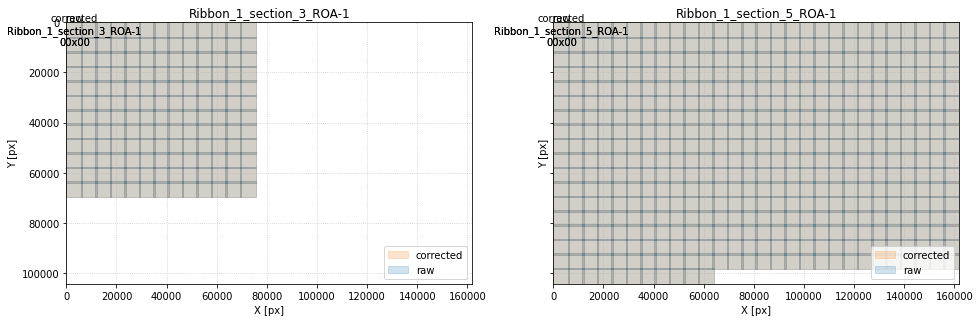

In [40]:
icatapi.plot_tile_map(stacks,
                      render=render)

## 4) Montage
---

Parse transformation data from `.../corrected/montage.xml` file.

In [45]:
# Initialize stacks DataFrame
df_stacks = pd.DataFrame()

# Loop through stacks
for stack in tqdm(stacks):

    # Create stack DataFrame
    df_stack = icatapi.create_stack_DataFrame(stack=stack,
                                              render=render)
    # Edit stack name
    df_stack['stack'] = stack + '_montaged'

    # Loop through section directories
    for z, dir_section in enumerate(dir_sections):

        # Parse montage.xml file
        fp = dir_section / 'corrected/montage.xml'
        soup = Soup(fp.read_text(), 'lxml')

        # Loop through "patches"
        for patch in soup.find_all('t2_patch'):

            # Parse transform data
            M00, M10, M01, M11, B0, B1 = [float(i) for i in re.findall(
                r'-?[\d.]+(?:[Ee]-?\d+)?', patch['transform'])]
            A = AffineModel(M00, M01, M10, M11, B0, B1)

            # Infer stack index
            row, col = [int(i) for i in patch['title'].split('_')[:2]]
            i = df_stack.loc[(df_stack['z'] == z) &\
                             (df_stack['imageRow'] == row) &\
                             (df_stack['imageCol'] == col)].index.item()
            df_stack.at[i, 'tforms'] = [A]

    # 
    df_stacks = pd.concat([df_stacks, df_stack])

# Sneak peak
df_stacks.groupby('stack')\
         .apply(lambda x: x.sample(4))

  0%|          | 0/2 [00:00<?, ?it/s]

tileId    z   width  height   minint  \
stack                                                                    
corrected_montaged 243  cor-S001-003x003  1.0  6400.0  6400.0  28276.0   
                   200  cor-S001-001x016  1.0  6400.0  6400.0  28276.0   
                   411  cor-S001-009x003  1.0  6400.0  6400.0  28276.0   
                   349  cor-S001-006x025  1.0  6400.0  6400.0  28276.0   
raw_montaged       205  raw-S001-001x021  1.0  6400.0  6400.0  54826.0   
                   584  raw-S001-015x008  1.0  6400.0  6400.0  54826.0   
                   84   raw-S000-006x006  0.0  6400.0  6400.0  53751.0   
                   372  raw-S001-007x020  1.0  6400.0  6400.0  54826.0   

                         maxint     imagePyramid               tforms  \
stack                                                                   
corrected_montaged 243  35255.0  [0, 1, 2, 3, 4]  [M=[[1.000000,0....   
                   200  35255.0  [0, 1, 2, 3, 4]  [M=[[1.000000,0....   
                   411  35255.0  [0, 1, 2, 3, 4]  [M=[[1.000000,0....   
                   349  35255.0  [0, 1, 2, 3, 4]  [M=[[1.000000,0....   
raw_montaged       205  60958.0     [0, 1, 2, 3]  [M=[[1.000000,0....   
                   584  60958.0     [0, 1, 2, 3]  [M=[[1.000000,0....   
                   84   60655.0     [0, 1, 2, 3]  [M=[[1.000000,0....   
                   372  60958.0     [0, 1, 2, 3]  [M=[[1.000000,0....   

                                     stack            sectionId  imageRow  \
stack                                                                       
corrected_montaged 243  corrected_montaged  Ribbon_1_section...         3   
                   200  corrected_montaged  Ribbon_1_section...         1   
                   411  corrected_montaged  Ribbon_1_section...         9   
                   349  corrected_montaged  Ribbon_1_section...         6   
raw_montaged       205        raw_montaged  Ribbon_1_section...         1   
                   584        raw_montaged  Ribbon_1_section...        15   
                   84         raw_montaged  Ribbon_1_section...         6   
                   372        raw_montaged  Ribbon_1_section...         7   

                        imageCol  
stack                             
corrected_montaged 243         3  
                   200        16  
                   411         3  
                   349        25  
raw_montaged       205        21  
                   584         8  
                   84          6  
                   372        20

#### Upload montage stacks

In [46]:
# Loop through stacks
for stack, df_stack in tqdm(df_stacks.groupby('stack')):

    # Set stack resolution
    Rx = 4
    Ry = 4
    Rz = 100

    # Create stacks
    upload_stack_DataFrame(df=df_stack,
                           name=stack,
                           stackResolutionX=Rx,
                           stackResolutionY=Ry,
                           stackResolutionZ=Rz,
                           render=render)

  0%|          | 0/2 [00:00<?, ?it/s]

Creating tile specifications for corrected_montaged...
Importing tile specifications to corrected_montaged...
Stack corrected_montaged created successfully.
Creating tile specifications for raw_montaged...
Importing tile specifications to raw_montaged...
Stack raw_montaged created successfully.


#### Inspect

  0%|          | 0/2 [00:00<?, ?it/s]

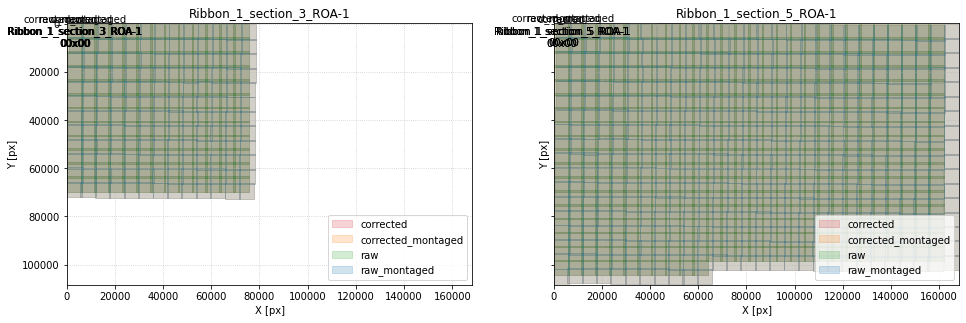

In [48]:
stacks_2_plot = renderapi.render.get_stacks_by_owner_project(render=render)
icatapi.plot_tile_map(stacks_2_plot,
                      render=render)

  0%|          | 0/8 [00:00<?, ?it/s]

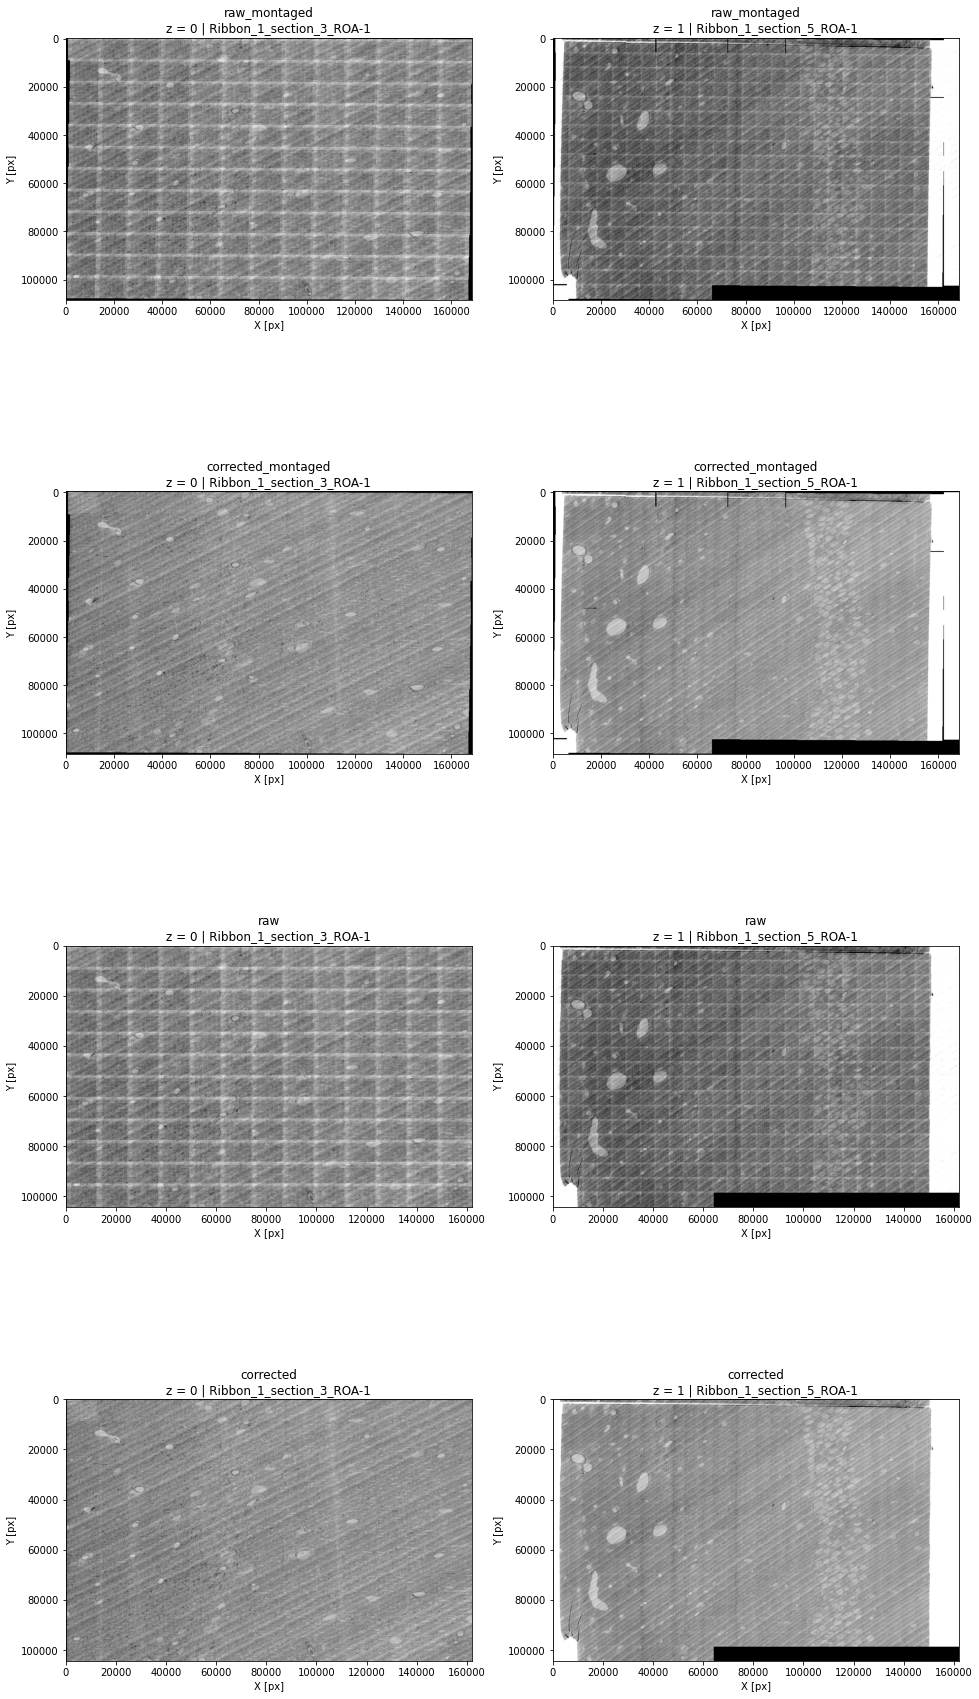

In [50]:
icatapi.plot_stacks(stacks_2_plot,
                    maxTileSpecsToRender=1000,
                    render=render)